In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

In [4]:
device ="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
!nvidia-smi

Thu Nov 21 18:01:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Data

In [7]:
# Create some data using the linear reg formula y=w*x+b
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02
#Create X and y (features and labels)
X = torch.arange(start, end , step).unsqueeze(dim=1)
y = weight*X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [8]:
#Split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test=X[train_split:],y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

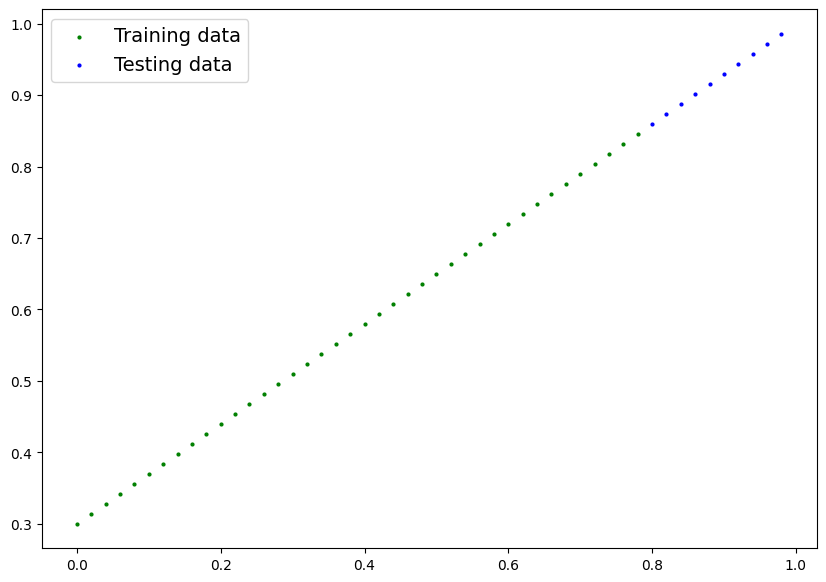

In [18]:
#plot the data
def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test, test_labels=y_test,predictions=None):
  plt.rcParams['figure.figsize'] = [10, 7]
  plt.scatter(train_data, train_labels, c='g', s=4, label='Training data')
  plt.scatter(test_data, test_labels, c='b', s=4, label='Testing data')
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
  plt.legend(prop={"size":14});
plot_predictions()

In [23]:
import torch.nn as nn


In [25]:
# Create a linear model by subclassing nn.module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating model params
    self.linear_layer= nn.Linear(in_features=1, out_features=1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [27]:
## Training the deep larning model.

next(model_1.parameters()).device

device(type='cpu')

In [28]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [31]:
# Setup Loss Function
loss_fn = nn.L1Loss() # Same as MAE
# Setup optimizer
optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [33]:
#Training loop
torch.manual_seed(42)
epochs = 200

X_train =X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  #1. forward pass
  y_pred = model_1(X_train)

  #2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Backpropagration
  loss.backward()

  #5. Optimizer step
  optimizer.step()

  #Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred=model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch%10 ==0:
    print(f"epoch: {epoch} | Loss: {loss} Test loss: {test_loss}")

epoch: 0 | Loss: 0.5551779866218567 Test loss: 0.5739762187004089
epoch: 10 | Loss: 0.439968079328537 Test loss: 0.4392664134502411
epoch: 20 | Loss: 0.3247582018375397 Test loss: 0.30455657839775085
epoch: 30 | Loss: 0.20954833924770355 Test loss: 0.16984669864177704
epoch: 40 | Loss: 0.09433845430612564 Test loss: 0.03513690456748009
epoch: 50 | Loss: 0.023886388167738914 Test loss: 0.04784907028079033
epoch: 60 | Loss: 0.019956795498728752 Test loss: 0.045803118497133255
epoch: 70 | Loss: 0.016517987474799156 Test loss: 0.037530567497015
epoch: 80 | Loss: 0.013089174404740334 Test loss: 0.02994490973651409
epoch: 90 | Loss: 0.009653178043663502 Test loss: 0.02167237363755703
epoch: 100 | Loss: 0.006215683650225401 Test loss: 0.014086711220443249
epoch: 110 | Loss: 0.00278724217787385 Test loss: 0.005814164876937866
epoch: 120 | Loss: 0.0012645035749301314 Test loss: 0.013801801018416882
epoch: 130 | Loss: 0.0012645035749301314 Test loss: 0.013801801018416882
epoch: 140 | Loss: 0.001

In [34]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [35]:
#Making predictions

model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

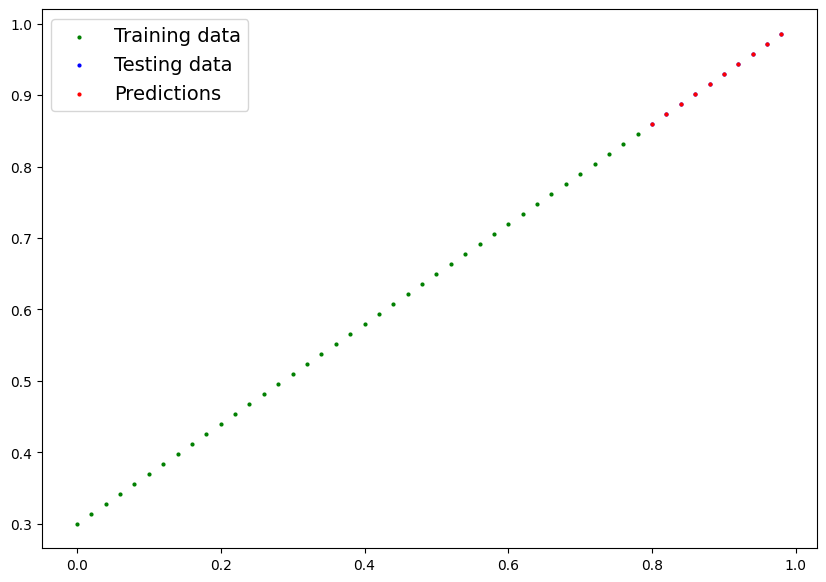

In [36]:
plot_predictions(predictions=y_preds.cpu())

In [38]:
## Saving and loading a training model
from pathlib import Path

MODEL_PATH= Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME="pytorch_workflow_model.pth"
MODEL_SAVE_PATH=MODEL_PATH/ MODEL_NAME
MODEL_SAVE_PATH
# save the model state dict

torch.save(obj=model_1.state_dict(), f = MODEL_SAVE_PATH)

In [41]:
#Load a pytorch

loaded_model_1 = LinearRegressionModel()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<ipython-input-41-0bd476d8f28c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [42]:
loaded_model_1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [44]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [45]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds=loaded_model_1(X_test)
y_preds==loaded_model_1_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')